In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
eps = {'a_x': 0.4, 'a_y': 0.5}
gl_bounds = {'x': [0, 1], 'y': [0, 1]} # global bounds
true_coords = {'x': 0.6, 'y': 0.4}

# polygons stored as lists of points in clockwise order
# [[[x1, y1], [x2, y2], [x3, y3], ...], ...]
polygons = [[[0, 0.8], [0, 1], [1, 1], [1, 0.4]],
            [[0, 0], [0, 0.6], [0.2, 0.2]],
            [[0, 0], [0.6, 0], [0.2, 0.2]]
            ]

for i in range(len(polygons)):
    polygons[i] = np.array(polygons[i])
unavail_segs = {'x': np.empty((0, 2)), 'y': np.empty((0, 2))} # new forbidden areas will be stored here

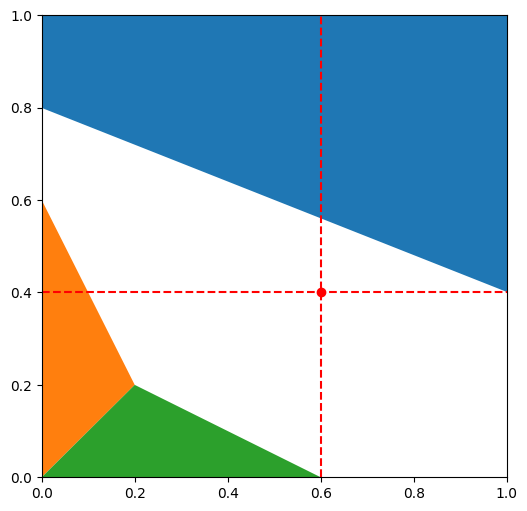

In [3]:
def draw(fig, ax, polygons, unavail_segs, true_coords, gl_bounds):
    for polygon in polygons:
        ax.fill(polygon[:, 0], polygon[:, 1])
    # draw all of the removed areas
    for axis in ['x', 'y']:
        other_axis = 'x' if axis == 'y' else 'y'
        num_segs = unavail_segs[axis].shape[0]
        for i in range(num_segs):
            x_ = [unavail_segs[axis][i, 0], unavail_segs[axis][i, 1], unavail_segs[axis][i, 1], unavail_segs[axis][i, 0]]
            y_ = [gl_bounds[other_axis][0], gl_bounds[other_axis][0], gl_bounds[other_axis][1], gl_bounds[other_axis][1]]
            if axis == 'y':
                x_, y_ = y_, x_
            ax.fill(x_, y_)
    ax.plot(true_coords['x'], true_coords['y'], marker='o', color='red')
    ax.vlines(true_coords['x'], gl_bounds['y'][0], gl_bounds['y'][1], colors='red', linestyle='dashed')
    ax.hlines(true_coords['y'], gl_bounds['x'][0], gl_bounds['x'][1], colors='red', linestyle='dashed')

    ax.set(xlim=gl_bounds['x'], ylim=gl_bounds['y'])

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
draw(fig, ax, polygons, unavail_segs, true_coords, gl_bounds)

In [4]:
# common with the two lines case
def intersect_segments(line1, line2):
    # https://stackoverflow.com/a/565282
    p1, p2 = line1[0], line2[0]
    vec1, vec2 = line1[1] - line1[0], line2[1] - line2[0]
    vec_cross_pr = np.cross(vec1, vec2)
    if vec_cross_pr == 0: # < 1e-6
        if np.cross(p2 - p1, vec1) == 0: # < 1e-6
            vec1_dot = np.dot(vec1, vec1)
            if vec1_dot == 0:
                return None
            t0 = np.dot(p2 - p1, vec1) / vec1_dot
            t1 = t0 + np.dot(vec2, vec1) / vec1_dot
            if t1 < t0:
                t0, t1 = t1, t0
            if t0 <= 1 and t1 >= 0: # [t0, t1] instersects [0, 1]
                t0 = max(0, t0)
                t1 = min(1, t1)
                return p1 + t0 * vec1, p1 + t1 * vec1 # ends of intersection segment
            else:
                None
        else:
            return None
    else:
        coef1 = np.cross(p2 - p1, vec2) / vec_cross_pr
        coef2 = np.cross(p2 - p1, vec1) / vec_cross_pr
        if 0 <= coef1 and coef1 <= 1 and 0 <= coef2 and coef2 <= 1:
            return p1 + coef1 * vec1
        return None

def segment_diff(st_coord, end_coord, sorted_segs):
    # we assume that all of the sorted_segs are disjointed
    if st_coord > end_coord:
        st_coord, end_coord = end_coord, st_coord
    if sorted_segs.shape[0] == 0:
        return st_coord, end_coord
    sorted_segs_coords = sorted_segs[:, 0]
    st_id = np.searchsorted(sorted_segs_coords, st_coord, side='right')
    end_id = np.searchsorted(sorted_segs_coords, end_coord, side='right')
    if st_id != 0 and sorted_segs[st_id - 1, 1] > st_coord: # start of segment is covered
        st_coord = sorted_segs[st_id - 1, 1]
    if end_id != 0 and sorted_segs[end_id - 1, 1] >= end_coord: # end of segment is covered
        end_coord = sorted_segs[end_id - 1, 0]
    if st_coord >= end_coord:
        return None, None
    return st_coord, end_coord

In [5]:
def add_unavail_seg(unavail_segs, seg):
    # we're keeping the segments disjoint and sorted
    st_id = np.searchsorted(unavail_segs[:, 0], seg[0], side='right')
    end_id = np.searchsorted(unavail_segs[:, 1], seg[1], side='left')
    if st_id - 1 == end_id:
        # segment we're trying to add lies fully inside of an already existing segment
        return unavail_segs
    del_st_id, del_end_id = None, None
    add_st_coord, add_end_coord = None, None
    add_id = None
    if st_id != 0 and seg[0] <= unavail_segs[st_id - 1, 1]:
        # the beginning of our segment lies inside of another segment
        add_st_coord = unavail_segs[st_id - 1, 0]
        del_st_id = st_id - 1
        add_id = st_id - 1
    else:
        add_st_coord = seg[0]
        del_st_id = st_id
        add_id = st_id
    if end_id < unavail_segs.shape[0] and seg[1] >= unavail_segs[end_id, 0]:
        # the ending of our segment lies inside of another segment
        add_end_coord = unavail_segs[end_id, 1]
        del_end_id = end_id
    else:
        add_end_coord = seg[1]
        del_end_id = end_id - 1

    unavail_segs = np.delete(unavail_segs, np.s_[del_st_id:del_end_id + 1], axis=0)
    unavail_segs = np.insert(unavail_segs, add_id, [add_st_coord, add_end_coord], axis=0)
    return unavail_segs

In [6]:
def intersect_with_polygon(line, polygon):
    num_vert = polygon.shape[0]
    inters = []
    for i in range(num_vert - 1):
        inter_line = intersect_segments(np.array([polygon[i], polygon[(i + 1) % num_vert]]),
                                        line)
        if type(inter_line) is tuple:
            for point in inter_line:
                inters.append(point)
        elif inter_line is not None:
            inters.append(inter_line)
    return inters

def free_segment_length(coord, axis, polygons, unavail_segs, gl_bounds):
    # axis == 'x' means we want to find the length of vertical segment,
    # i.e. x coordinate is fixed and vice versa
    other_axis = 'x' if axis == 'y' else 'y'
    sort_axis = 0 if axis == 'y' else 1
    true_line = np.array([[gl_bounds['x'][0], coord], [gl_bounds['x'][1], coord]]) if axis == 'y' \
                    else np.array([[coord, gl_bounds['y'][0]], [coord, gl_bounds['y'][1]]])
    segs_copy = np.copy(unavail_segs[other_axis])
    for polygon in polygons:
        inters = np.array(intersect_with_polygon(true_line, polygon))
        if inters.shape[0] == 0:
            continue
        coords = np.unique(inters[:, sort_axis]) # np.unique returns sorted array
        if coords.shape[0] == 2: # for convex polygons max is 2
            segs_copy = add_unavail_seg(segs_copy, coords)
        elif coords.shape[0] > 2:
            print('something went wrong')
    st_coord, end_coord = segment_diff(gl_bounds[other_axis][0], gl_bounds[other_axis][1], segs_copy)
    if st_coord is None:
        return 0
    return end_coord - st_coord

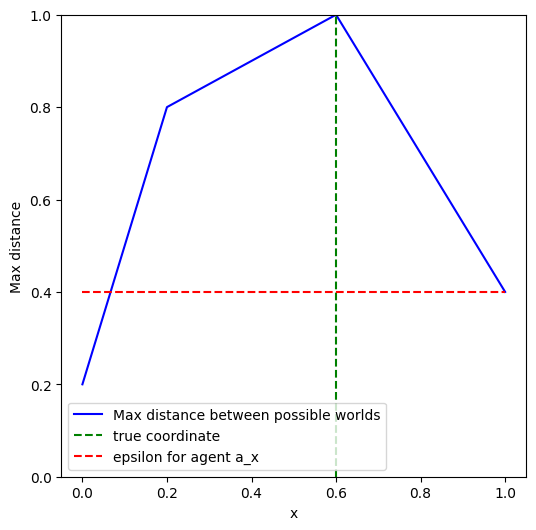

In [7]:
# functions are common with the two lines case
def plot_data(cois, axis, polygons, unavail_segs, gl_bounds):
    # return max lengths for points coordinates in axis
    x = []
    y = []
    for coi in cois:
        x.append(coi)
        y.append(free_segment_length(coi, axis, polygons, unavail_segs, gl_bounds))
    return x, y

axis = 'x'
sort_axis = 0 if axis == 'x' else 1
cois = np.array([gl_bounds[axis][0], gl_bounds[axis][1]])
for polygon in polygons:
    cois = np.concatenate((cois, polygon[:, sort_axis]))
cois.flatten()
cois = np.unique(cois)

x, y = plot_data(cois, axis, polygons, unavail_segs, gl_bounds)

def draw_plot(fig, ax, piecewise_x, piecewise_y, axis, eps, true_coords, gl_bounds):
    other_axis = 'x' if axis == 'y' else 'y'
    label = 'Max distance between possible worlds'
    for i in range(len(piecewise_x)):
        x = piecewise_x[i]
        y = piecewise_y[i]
        ax.plot(x, y, label=label, color='blue')
        label = None

    ax.vlines(true_coords[axis], gl_bounds[other_axis][0], gl_bounds[other_axis][1], colors='green', \
                                                        linestyle='dashed', label = 'true coordinate')
    ax.hlines(eps['a_' + axis], 0, 1, colors='red', linestyle='dashed', label='epsilon for agent a_' + axis)
    ax.set_ylim(gl_bounds[other_axis][0], gl_bounds[other_axis][1])
    ax.set_xlabel(axis)
    ax.set_ylabel('Max distance')
    ax.legend()

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
draw_plot(fig, ax, [x], [y], axis, eps, true_coords, gl_bounds)
plt.show()

[[0.0, 0.06666666666666665]]

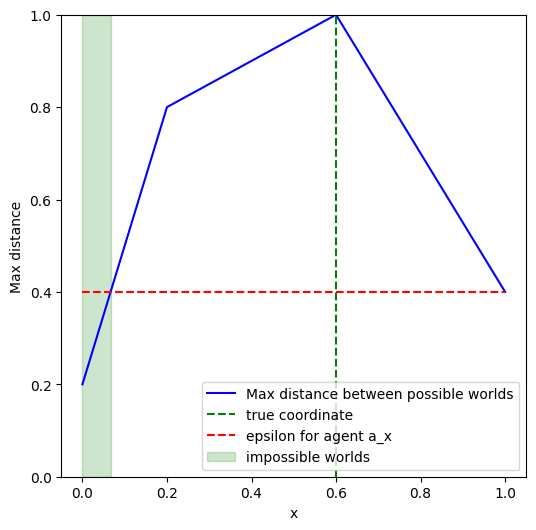

In [8]:
def draw_impossible_worlds(fig, ax, piecewise_x, piecewise_y, eps, gl_bounds, axis, remove_small):
    # need to add impossible segments
    rel_tol = 1e-7
    imposs_x = []
    tmp = []

    for i in range(len(piecewise_x)):
        x = piecewise_x[i]
        y = piecewise_y[i]
        for j in range(len(x) - 1):
            inter_point = intersect_segments(np.array([[x[j], y[j]], [x[j + 1], y[j + 1]]]), \
                                            np.array([[gl_bounds[axis][0], eps['a_' + axis]], [gl_bounds[axis][1], eps['a_' + axis]]]))
            if (remove_small and y[j] < eps['a_' + axis]) or ((not remove_small) and y[j] >= eps['a_' + axis]):
                tmp.append(x[j])
            elif tmp:
                if not math.isclose(tmp[0], tmp[-1], rel_tol=rel_tol):
                    imposs_x.append([tmp[0], tmp[-1]])
                tmp = []
            if not inter_point is None:
                tmp.append(inter_point[0])

        if (remove_small and y[-1] < eps['a_' + axis]) or (not remove_small and y[-1] >= eps['a_' + axis]):
            tmp.append(x[-1])
        if tmp:
            if not math.isclose(tmp[0], tmp[-1], rel_tol=rel_tol):
                imposs_x.append([tmp[0], tmp[-1]])
            tmp = []

    draw_plot(fig, ax, piecewise_x, piecewise_y, axis, eps, true_coords, gl_bounds)
    label = 'impossible worlds'

    for seg in imposs_x:
        ax.fill_between(seg, gl_bounds[axis][0], gl_bounds[axis][1], color='green', alpha=0.2, label=label)
        label = None
    ax.legend()
    return imposs_x


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
draw_impossible_worlds(fig, ax, [x], [y], eps, gl_bounds, 'x', True)

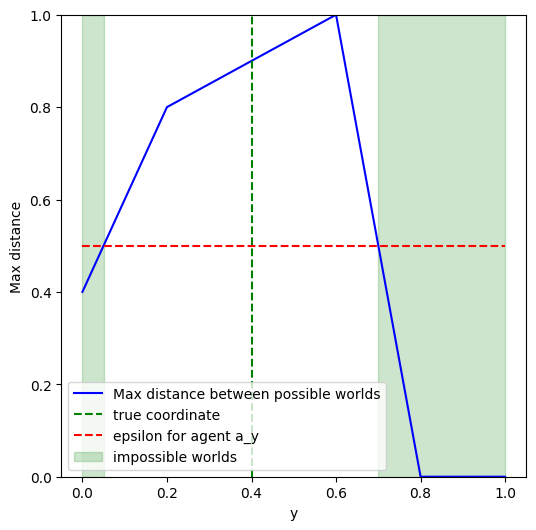

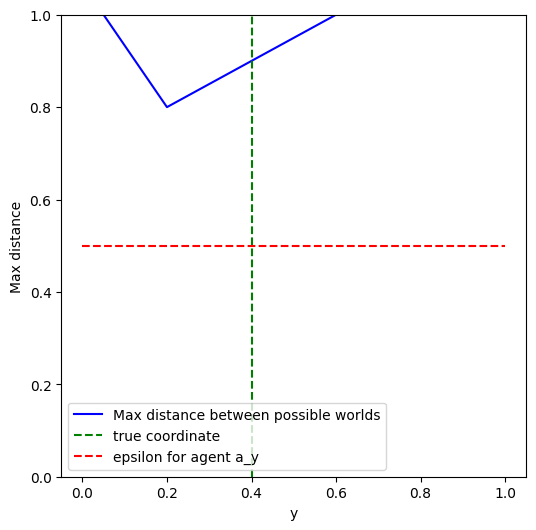

In [9]:
def remove_impossible_areas(polygons, unavail_segs, axis, remove_small, eps, gl_bounds):
    other_axis = 'x' if axis == 'y' else 'y'
    sort_axis = 0 if axis == 'x' else 1
    cois = np.array([gl_bounds[axis][0], gl_bounds[axis][1]]) # coordinates of interest
    for polygon in polygons:
        cois = np.concatenate((cois, polygon[:, sort_axis].flatten()))
    cois = np.concatenate((cois, unavail_segs[axis].flatten()))

    # calculate intersections with impossible areas
    num_segs_oa = unavail_segs[other_axis].shape[0]
    for i in range(num_segs_oa):
        seg = unavail_segs[other_axis][i]
        for j in range(2):
            tmp_line = np.array([[seg[j], gl_bounds['y'][0]], [seg[j], gl_bounds['y'][1]]]) if axis == 'y' else \
                        np.array([[gl_bounds['x'][0], seg[j]], [gl_bounds['x'][1], seg[j]]])
            for polygon in polygons:
                inters = np.array(intersect_with_polygon(tmp_line, polygon))
                if inters.shape[0] != 0:
                    cois = np.concatenate((cois, inters[:, sort_axis]))

    cois = np.unique(cois) # np.unique returns sorted array

    x, y = plot_data(cois, axis, polygons, unavail_segs, gl_bounds)

    # remove unavail_segs[axis]
    num_segs = unavail_segs[axis].shape[0]
    piecewise_x = []
    piecewise_y = []
    last_id = 0
    tmp_x, tmp_y = [], []
    for i in range(num_segs):
        seg = unavail_segs[axis][i]
        st_id = np.searchsorted(x, seg[0], side='right')
        end_id = np.searchsorted(x, seg[1], side='left')
        piecewise_x.append(tmp_x + x[last_id:st_id])
        piecewise_y.append(tmp_y + y[last_id:st_id])
        piecewise_x[-1].append(seg[0])
        piecewise_y[-1].append(y[st_id - 1] + (y[st_id] - y[st_id - 1]) * (seg[0] - x[st_id - 1]) / (x[st_id] - x[st_id - 1]))

        tmp_x = [seg[1]]
        tmp_y = [y[end_id - 1] + (y[end_id] - y[end_id - 1]) * (seg[1] - x[end_id - 1]) / (x[end_id] - x[end_id - 1])]
        last_id = end_id
    piecewise_x.append(tmp_x + x[last_id:])
    piecewise_y.append(tmp_y + y[last_id:])
    if math.isclose(piecewise_x[0][0], piecewise_x[0][1]):
        piecewise_x = piecewise_x[1:]
        piecewise_y = piecewise_y[1:]
    if math.isclose(piecewise_x[-1][0], piecewise_x[-1][1]):
        piecewise_x = piecewise_x[:-1]
        piecewise_y = piecewise_y[:-1]

    fig, ax = plt.subplots(figsize=(6, 6))
    imposs_x = draw_impossible_worlds(fig, ax, piecewise_x, piecewise_y, eps, gl_bounds, axis, remove_small)
    plt.show()

    for seg in imposs_x:
        unavail_segs[axis] = add_unavail_seg(unavail_segs[axis], seg)

    return len(imposs_x) > 0

remove_impossible_areas(polygons, unavail_segs, 'y', True, eps, gl_bounds)
remove_impossible_areas(polygons, unavail_segs, 'y', True, eps, gl_bounds)
unavail_segs = {'x': np.empty((0, 2)), 'y': np.empty((0, 2))}

In [10]:
def run_process(eps, gl_bounds, true_coords, lines, unavail_segs):
    axis, other_axis = 'x', 'y'
    has_changed_prev, has_changed = True, True
    step = 1

    while has_changed_prev or has_changed:
        remove_small = False if free_segment_length(true_coords[axis], axis, lines, unavail_segs, gl_bounds) < eps['a_' + axis] \
                        else True
        if remove_small:
            print('agent a_' + axis + ' doesn\'t know')
        else:
            print('agent a_' + axis + ' knows')

        has_changed_prev = has_changed
        has_changed = remove_impossible_areas(lines, unavail_segs, axis, remove_small, eps, gl_bounds)

        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
        draw(fig, ax, lines, unavail_segs, true_coords, gl_bounds)

        axis, other_axis = other_axis, axis
        step += 1
    return step

agent a_x doesn't know


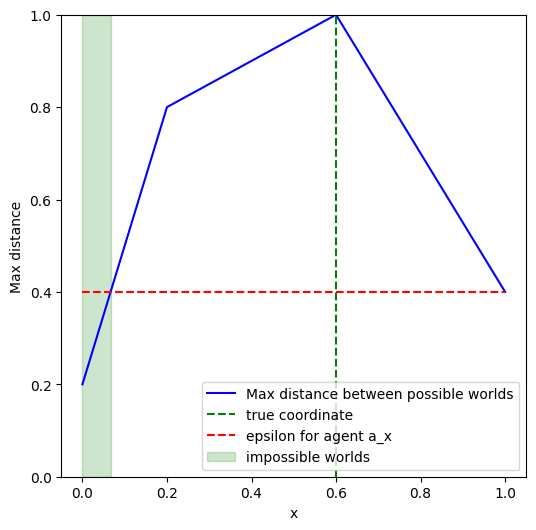

agent a_y doesn't know


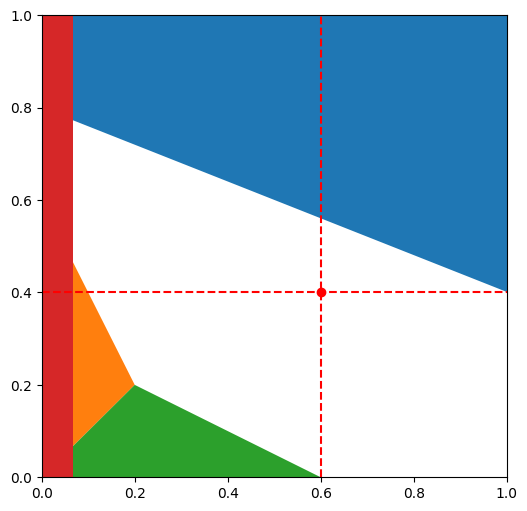

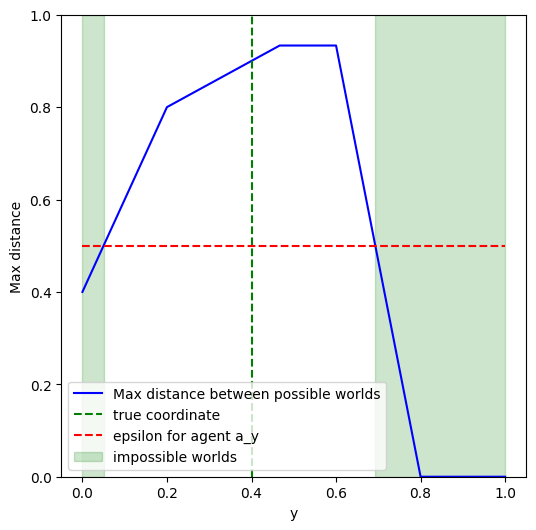

agent a_x doesn't know


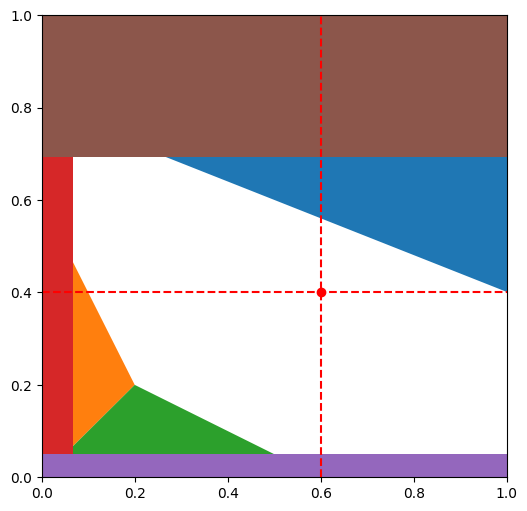

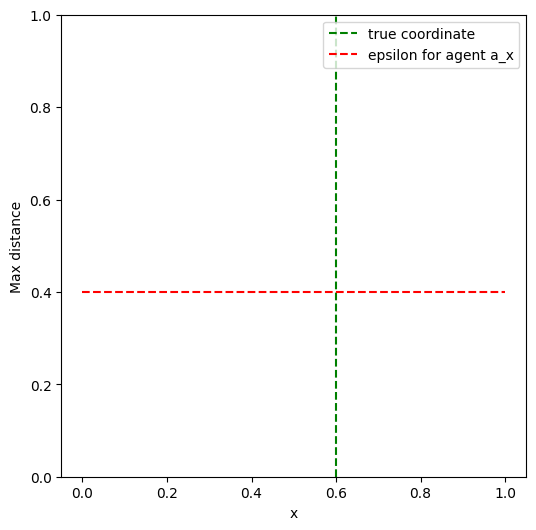

agent a_y doesn't know


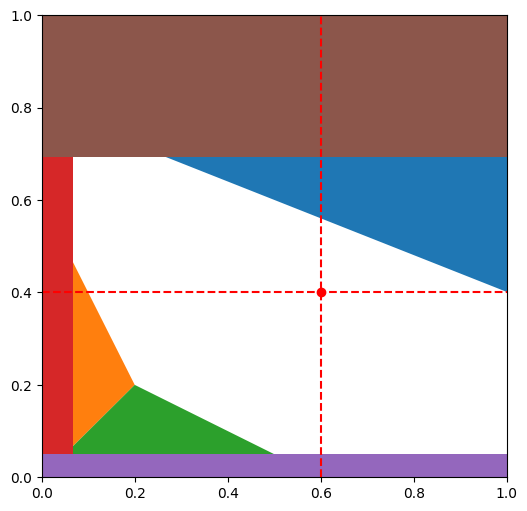

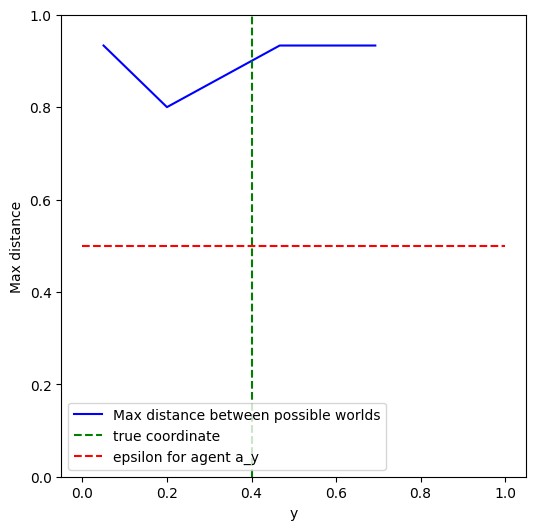

5

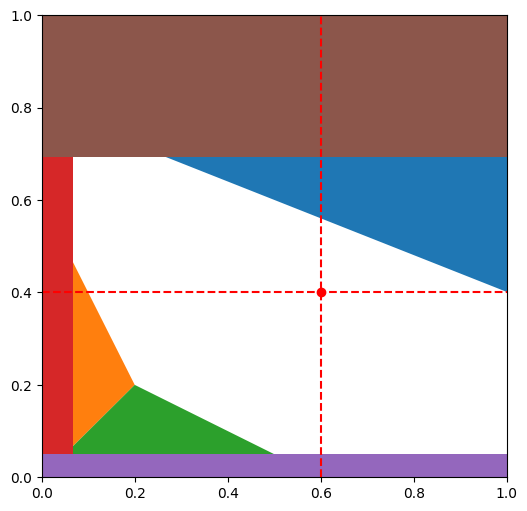

In [11]:
eps = {'a_x': 0.4, 'a_y': 0.5}
gl_bounds = {'x': [0, 1], 'y': [0, 1]} # global bounds
true_coords = {'x': 0.6, 'y': 0.4}

# polygons stored as lists of points in clockwise order
# [[[x1, y1], [x2, y2], [x3, y3], ...], ...]
polygons = [[[0, 0.8], [0, 1], [1, 1], [1, 0.4]],
            [[0, 0], [0, 0.6], [0.2, 0.2]],
            [[0, 0], [0.6, 0], [0.2, 0.2]]
            ]

for i in range(len(polygons)):
    polygons[i] = np.array(polygons[i])
unavail_segs = {'x': np.empty((0, 2)), 'y': np.empty((0, 2))} # new forbidden areas will be stored here

run_process(eps, gl_bounds, true_coords, polygons, unavail_segs)